In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models import MLP, CNN_MNIST
from dataset import ImageFolderDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))

path_data = Path.cwd().parent / 'stylegan2' / 'data'
path_results = Path.cwd().parent / 'stylegan2' / 'results'

use_stylegan2_dataset = True

Using cuda device


In [11]:
if use_stylegan2_dataset:
    dataset_train = 'mnist_stylegan2_blur_noise_maxSeverity3_proba50'
    path_dataset = path_data / 'MNIST' / f'{dataset_train}.zip'
    train_data = ImageFolderDataset(path_dataset, use_labels=True)

    dataset_test = 'mnistTest_stylegan2_blur_noise_maxSeverity3_proba50'
    path_dataset = path_data / 'MNIST' / f'{dataset_test}.zip'
    test_data = ImageFolderDataset(path_dataset, use_labels=True)

else:
    train_data = datasets.MNIST(
        root='../data',
        train=True,
        download=True,
        transform=ToTensor()
    )
    test_data = datasets.MNIST(
        root='../data',
        train=False,
        download=True,
        transform=ToTensor()
    )

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


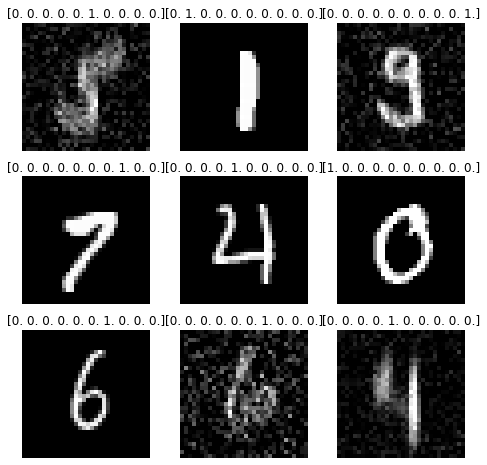

In [3]:
fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

In [4]:
BATCH_SIZE = 64
HIDDEN_DIM = 64
NB_EPOCHS = 10
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [5]:
def train(dataloader, model, loss_function, optimizer):

    model.train()

    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):

        if use_stylegan2_dataset:  
            X = (X / 255)[:, :, 2:30, 2:30]
            y = y.argmax(1)
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_function(y_pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print('[{}/{}] loss: {}'.format(batch*len(X), size, loss))

            
def test(dataloader, model, loss_function, device):

    model.eval()

    cum_loss, correct_pred = 0, 0
    for X, y in dataloader:
        
        if use_stylegan2_dataset:  
            X = (X / 255)[:, :, 2:30, 2:30]
            y = y.argmax(1)
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            # Compute prediction, loss and correct predictions
            y_pred = model(X)
            loss = loss_function(y_pred, y)
            correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()

            cum_loss += loss
            correct_pred += correct

    average_loss = cum_loss / len(dataloader)
    average_accuracy = correct_pred / len(dataloader.dataset)

    print('Test error: {}\nAccuracy {}\n'.format(average_loss, average_accuracy))

    return average_loss, average_accuracy

In [6]:
# model = MLP().to(device)
model = CNN_MNIST().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
test(test_dataloader, model, loss_function, device)
for e in range(1, NB_EPOCHS+1):
    print(f'Epoch {e}/{NB_EPOCHS}\n-------------------')
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model, loss_function, device)

Test error: 2.3046178817749023
Accuracy 0.0509

Epoch 1/10
-------------------
[0/60000] loss: 2.3160808086395264
[6400/60000] loss: 0.4729800522327423
[12800/60000] loss: 0.15261709690093994
[19200/60000] loss: 0.1834801435470581
[25600/60000] loss: 0.11698009818792343
[32000/60000] loss: 0.12682703137397766
[38400/60000] loss: 0.25057172775268555
[44800/60000] loss: 0.19584178924560547
[51200/60000] loss: 0.4115842878818512
[57600/60000] loss: 0.20546101033687592
Test error: 0.2710570991039276
Accuracy 0.9303

Epoch 2/10
-------------------
[0/60000] loss: 0.17428690195083618
[6400/60000] loss: 0.292815625667572
[12800/60000] loss: 0.060224469751119614
[19200/60000] loss: 0.07524963468313217
[25600/60000] loss: 0.060079436749219894
[32000/60000] loss: 0.06735412031412125
[38400/60000] loss: 0.17187203466892242
[44800/60000] loss: 0.20639650523662567
[51200/60000] loss: 0.44753408432006836
[57600/60000] loss: 0.08465741574764252
Test error: 0.23962907493114471
Accuracy 0.9379

Epoch 3

In [12]:
save_path = str(path_results / 'classifiers' /  f'CNN_{dataset_train}_{datetime.now().strftime("%Y%m%d_%H%M")}.pth')
torch.save(model.state_dict(), save_path)

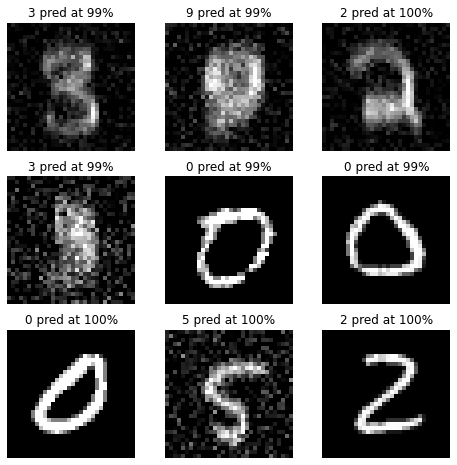

In [27]:
model.eval()

fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    
    if use_stylegan2_dataset:  
        img = torch.tensor(img)
        x = img.unsqueeze(0).to(device)
        x = (x / 255)[:, :, 2:30, 2:30]
        label = label.argmax()
    else:
        x = img.unsqueeze(0).to(device)
    proba = int(100*F.softmax(model(x), dim=1)[0, label])
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{label} pred at {proba}%')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')